In [47]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import random
#import pylops # might not need
import math
import pyproximal

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from keras.saving import register_keras_serializable
from tensorflow.test import compute_gradient

from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.optimize import minimize

In [15]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


### Autoencoder

#### Training the autoencoder

In [3]:
# code from: https://www.tensorflow.org/tutorials/generative/autoencoder

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255. #normalize the data
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


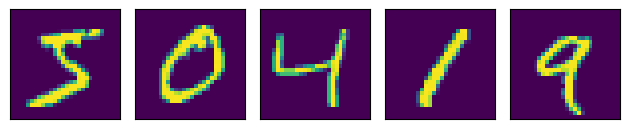

In [5]:
# representation training dataset
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    x = x_train[i]
    ax[i].imshow(np.real(x).reshape((28,28)),clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

In [11]:
@register_keras_serializable()
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)
print(len(autoencoder.layers))
print(shape)

2
(28, 28)


In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError()) # configuration of the model for training, adam is a stochastic gradient method that estimates moments
autoencoder.fit(x_train, x_train,
                epochs=10, # number of times the entire training dataset is run through the model
                shuffle=True, # shuffles the data set before each training epoch
                validation_data=(x_test, x_test)) # validation at the end of each epoch
                # batch size is 32 by default

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0438 - val_loss: 0.0092
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0080 - val_loss: 0.0055
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0040 - val_loss: 0.0039


##### Load & save autoencoder model

In [13]:
autoencoder.save('autoencoder_10epochs_mnist.keras')

In [ ]:
autoencoder2 = tf.keras.models.load_model('autoencoder_10epochs_mnist.keras')
autoencoder2.summary()

# doesnt work yet, have to read up on it

TypeError: <class '__main__.Autoencoder'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'Autoencoder', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'Custom>Autoencoder', 'build_config': {'input_shape': [32, 28, 28]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.Autoencoder'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of Autoencoder from its config.

Received config={'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}

Error encountered during deserialization: __init__() got an unexpected keyword argument 'trainable'

(10000, 64)
(10000, 28, 28)


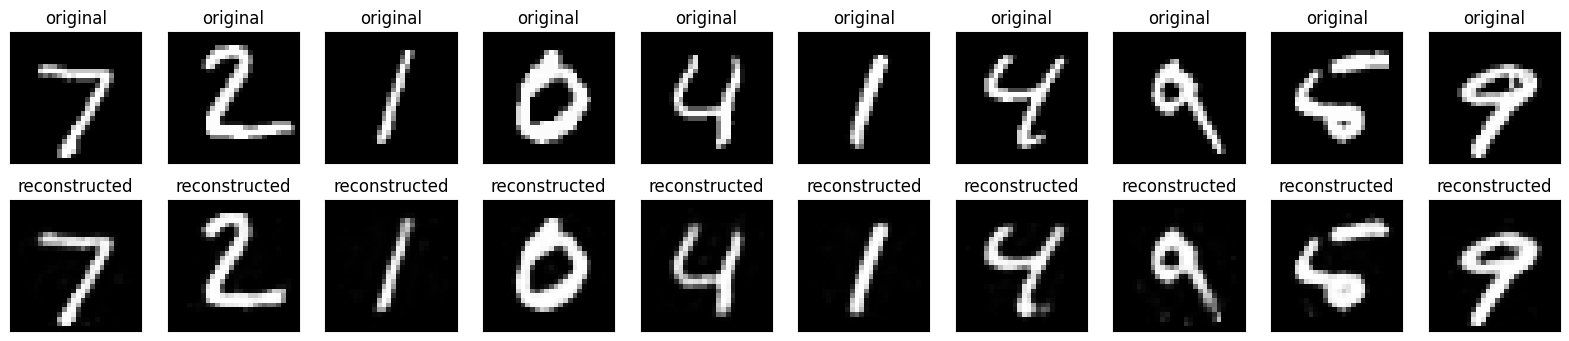

Model: "autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (32, 64)               │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 28, 28)           │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,602 (1.16 MB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 202,402 (790.64 KB)

<Sequential name=sequential_3, built=True>


In [15]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
print(encoded_imgs.shape)
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print(decoded_imgs.shape)

ns = 10
plt.figure(figsize=(20, 4))
for i in range(ns):
  # display original
  ax = plt.subplot(2, ns, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, ns, i + 1 + ns)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

autoencoder.summary()
print(autoencoder.decoder)



#### Extracting autoencoder function

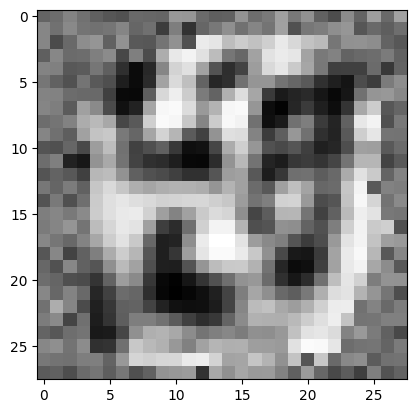

In [17]:
# random input looks like this
z_random = np.random.normal(size=(1,64))
test_z = autoencoder.decoder(z_random) #test_z is a tf 

plt.figure()
plt.imshow(test_z[0])

In [18]:
# compute gradient function
def grad_decoder_1D(decoder, input_dim):
    '''
    first wrap decoder into tensorflow function to improve computation speed
    specifically also changes 2D output to 1D output

    input:
        decoder:        the autoencoder.decoder as input, maps 1D input z to 2D output
        input_dim:      int, size of the input dimension (usually representing latent space)

    output:
        jac_operator:   a function that computes the jacobian wrt input z and returns the gradients and output in terms of a tensor

    '''
    decoder_1D = lambda x : tf.reshape(decoder(x), [tf.shape(decoder(x))[0], -1])

    @tf.function(reduce_retracing=True)
    def jac_operator(z):
        '''
        input:
            z:      vector in the latent space, size = (sample size, dimension latent space)
        '''
        z = tf.convert_to_tensor(z) # leaves z unchanged if input is already in form of tf.tensor
        z = tf.reshape(z, [-1, input_dim]) # leaves z unchanged if size is already (sample size, dim latent space), else performs 2D array conversion

        with tf.GradientTape() as tape:
            tape.watch(z)           # record derivatives
            output = decoder_1D(z)     # the function to compute the derivative of

        # gradient wrt z = (batch size, input length)
        gradients = tape.batch_jacobian(output, z)

        return output, gradients
    
    return jac_operator

def make_tensor(z):
    return tf.convert_to_tensor(z, dtype=tf.float32)


decoderfun_2D  = lambda z : autoencoder.decoder(z_random) 

test_jac = grad_decoder_1D(decoderfun_2D, latent_dim)
output, grads = test_jac(z_random)

print(output.shape)
print(grads.shape)

(1, 784)
(1, 784, 64)


### Set-up from ptygenography

In [19]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)
    
    yp = A.eval(xc)
    Dy = A.jac(xc)
    print(Dy.shape)

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc
    print(gradc.shape)
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs, result

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

In [20]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv) # rmatvec is conjugate operation, so A^H * v
    
    return A

In [21]:
# parameters
mx      = 100       # number of masks
nx      = shape[0]  # one side of the image
n       = nx**2     # total length of one image

In [22]:
# define forward operator with binary masks
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
print(MF.shape)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

(78400, 784)


In [44]:
# get prior from decoder
k               = latent_dim

decoderfun_2D   = lambda z : autoencoder.decoder(z) #input: z as at least 2D np array, outputs tf array
decoderfun_1D   = grad_decoder_1D(decoderfun_2D, latent_dim)

#define generative models
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

G = Op(fun = lambda z : decoderfun_1D(make_tensor(z))[0].numpy(), 
       jac = lambda z: (
                lambda grads: LinearOperator(
                    (n, k),
                    matvec=lambda v: grads @ v,
                    rmatvec=lambda v: np.conj(grads.T) @ v
                )
            )(decoderfun_1D(make_tensor(z))[1].numpy()), 
        shape = (n,k))

H = Op(fun = lambda z : decoderfun_1D(make_tensor(z[:,:k]))[0].numpy() + z[:,k:], 
       jac = lambda z: (
                lambda grads: LinearOperator(
                    (n, k+n),
                    matvec=lambda v: grads @ v,
                    rmatvec=lambda v: np.conj(grads.T) @ v
                )
            )(np.concatenate((decoderfun_1D(make_tensor(z[:,:k]))[1].numpy()[0], np.eye(n)), axis=1)),  
        shape=(n, k+n))


#G = Op(fun = lambda z : decoderfun_1D(make_tensor(z))[0].numpy(),  
       #jac = lambda z : LinearOperator((n, k), matvec = lambda x : decoderfun_1D(make_tensor(z))[1].numpy()@x, rmatvec = lambda y : np.conj(decoderfun_1D(make_tensor(z))[1].numpy().T)@y), shape=(n,k))
#H = Op(fun = lambda z : mu + C@z, jac = lambda z : LinearOperator((n, k+n), matvec = lambda z : C@z, rmatvec = lambda z : np.conj(C.T)@z), shape=(n,k+n))

# define weights
w = 1

# test
print(G.eval(z_random).shape)
print(G.jac(z_random).shape)

h_random = np.random.normal(size=(1,k+n))
print(h_random.shape)
print(H.eval(h_random).shape)
print(H.jac(h_random).shape)

print(z_random.shape)
G_test = G.jac(z_random)@np.eye(k)

print(G_test.shape)
type(G_test)

H_test = H.jac(h_random)@np.eye(n+k)

(1, 784)
(784, 64)
(1, 848)
(1, 784)
(784, 848)
(1, 64)
(784, 64)


In [57]:
def verify_jacobian(decoderfun_1D, z, eps=1e-4, atol=1e-2, rtol=1e-2):
    output, jac = decoderfun_1D(z)
    output = output.numpy().flatten()
    jac = jac.numpy().squeeze()

    k = z.shape[-1]
    n = output.shape[-1]
    approx_jac = np.zeros((n, k))

    for j in range(k):
        dz = np.zeros_like(z)
        dz[0, j] = eps
        f_plus = decoderfun_1D(z + dz)[0].numpy().flatten()
        f_minus = decoderfun_1D(z - dz)[0].numpy().flatten()
        approx_jac[:, j] = (f_plus - f_minus) / (2 * eps)

    is_close = np.allclose(approx_jac, jac, rtol=rtol, atol=atol)
    return is_close, approx_jac, jac

is_good, J_numeric, J_auto = verify_jacobian(decoderfun_1D, z_random)
print("Jacobian is good:", is_good)

print(J_numeric.shape)
type(J_numeric)

print(np.max(np.abs(J_numeric-G_test)))

Jacobian is good: True
(784, 64)
0.0006511863321065903


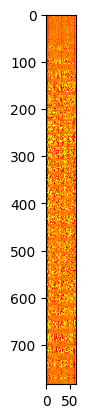

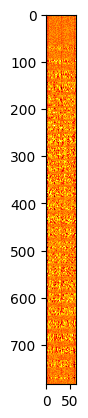

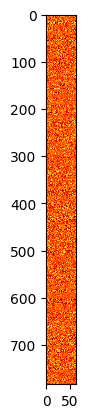

In [ ]:
plt.figure()
plt.imshow(G_test, cmap='hot', interpolation='nearest')
plt.show()

plt.figure()
plt.imshow(J_numeric, cmap='hot', interpolation='nearest')
plt.show()

(10000, 64)
(1, 64)
(1, 784)
(1, 28, 28)


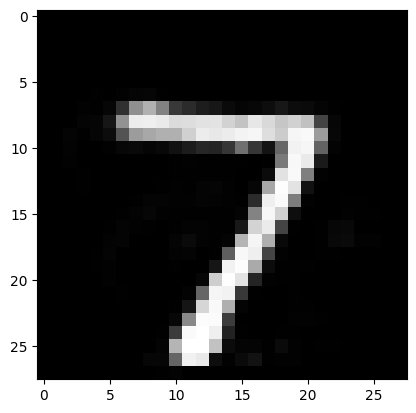

In [29]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
print(encoded_imgs.shape)

one_test_img = np.zeros((1,latent_dim))
one_test_img[0,:] = encoded_imgs[0,:]
print(one_test_img.shape)

test_G = G.eval(one_test_img)
print(test_G.shape)
restored = test_G.reshape((1,nx,nx))
print(restored.shape)

plt.figure()
plt.imshow(restored[0])
